Please create a folder named `data` in the main directory and place the following files inside it:

- `Reddit-Threads_2020-2021.csv`
- `Reddit-Threads_2022-2023.csv`

In [1]:
import pandas as pd
import ast
import torch
import torch.nn as nn
import transformers
from transformers import pipeline
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import requests
import os
from dotenv import load_dotenv
import time
from huggingface_hub import login

if torch.cuda.is_available():
    device = torch.device("cuda")
    device_name = torch.cuda.get_device_name(torch.cuda.current_device())
    print(f'Device in use: {device_name}')
else:
    device = torch.device("cpu")
    print('Device in use: CPU')

load_dotenv()

Device in use: NVIDIA GeForce RTX 3060 Ti


True

# Reading in data

In [2]:
df = pd.DataFrame()

###   SMALL DATASET   ###
df = pd.read_csv('data/Reddit-Threads_2020-2021.csv', nrows=10000)
print(df.head())
###   SMALL DATASET   ###

###   FULL DATASET   ###
# chunk_size = 10000
# for chunk in pd.read_csv('data/Reddit-Threads_2020-2021.csv', chunksize=chunk_size):
#     print(chunk.head())  
#     df = pd.concat([df, chunk])
# for chunk in pd.read_csv('data/Reddit-Threads_2022-2023.csv', chunksize=chunk_size):
#     print(chunk.head())  
#     df = pd.concat([df, chunk])
###   FULL DATASET   ###

print(df.shape)


                                                text            timestamp  \
0                                      STI chiong ah  2020-05-14 12:35:30   
1  Look on the bright side - you'll never make th...  2020-02-09 17:23:24   
2  For posts flaired as such (by OP), we will be ...  2021-04-06 18:08:59   
3  sounds q fucked up if no concern for each othe...  2021-01-22 14:22:42   
4  Chinese media reported a while ago: https://ww...  2020-03-26 04:51:22   

         username                                               link  \
0       iamabear1  /r/singapore/comments/gjjem5/covid19_8663_busi...   
1          lkc159  /r/singapore/comments/f15aks/did_i_just_get_sc...   
2   AutoModerator  /r/singapore/comments/maajuo/a_compilation_of_...   
3       [deleted]  /r/singapore/comments/l28wfr/rsingapore_random...   
4  localinfluenza  /r/singapore/comments/fp5hgu/pcf_cluster_anoth...   

     link_id   parent_id       id subreddit_id  \
0  t3_gjjem5   t3_gjjem5  fqljinp     t5_2qh8c   
1  t

# Cleaning

In [3]:
df['moderation'] = df['moderation'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
moderation_dicts = df['moderation']
moderation_normalized = pd.json_normalize(moderation_dicts)
# print(moderation_normalized)
df = df.reset_index(drop=True)
moderation_normalized = moderation_normalized.reset_index(drop=True)
df_normalized = pd.concat([df.drop(columns=['moderation']), moderation_normalized], axis=1)
print(df_normalized.columns)

### removing deleted or removed text ###
df_normalized = df_normalized[df_normalized['text'] != '[deleted]']
df_normalized = df_normalized[df_normalized['text'] != '[removed]']
### removing deleted or removed text ###

### stop word removal ###
stop_words = set(stopwords.words('english'))

def remove_stop_words(text):
    if isinstance(text, str):  # Check if the text is a string
        return ' '.join([word for word in text.split() if word.lower() not in stop_words])
    return text 

df_normalized['text'] = df_normalized['text'].apply(remove_stop_words)
print(df_normalized['text'])
# print(stop_words)
### stop word removal ###

Index(['text', 'timestamp', 'username', 'link', 'link_id', 'parent_id', 'id',
       'subreddit_id', 'removal_reason', 'collapsed', 'collapsed_reason',
       'controversiality', 'author_is_blocked', 'collapsed_reason_code'],
      dtype='object')
0                                           STI chiong ah
1       Look bright side - never make mistake again, l...
2       posts flaired (by OP), exercising greater mode...
3                             sounds q fucked concern leh
4       Chinese media reported ago: https://www.zaobao...
                              ...                        
9994    Parents car workshop owners. Middle upper midd...
9995    Damn, Frostmourne sword going deadly spend day...
9997    need someone Microsoft Flight Sim 2020 fly Sin...
9998    wow ew, read said really don’t like guy. heck ...
9999    saying Chinese: 大义灭亲 (Remove kin greater good)...
Name: text, Length: 8970, dtype: object


In [4]:
print(df.columns)

Index(['text', 'timestamp', 'username', 'link', 'link_id', 'parent_id', 'id',
       'subreddit_id', 'moderation'],
      dtype='object')


C:\Users\Ethan\AppData\Local\Temp\ipykernel_36916\1013352707.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Not specified' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_for_plot.fillna('Not specified', inplace=True)


KeyError: 'banned_at_utc'

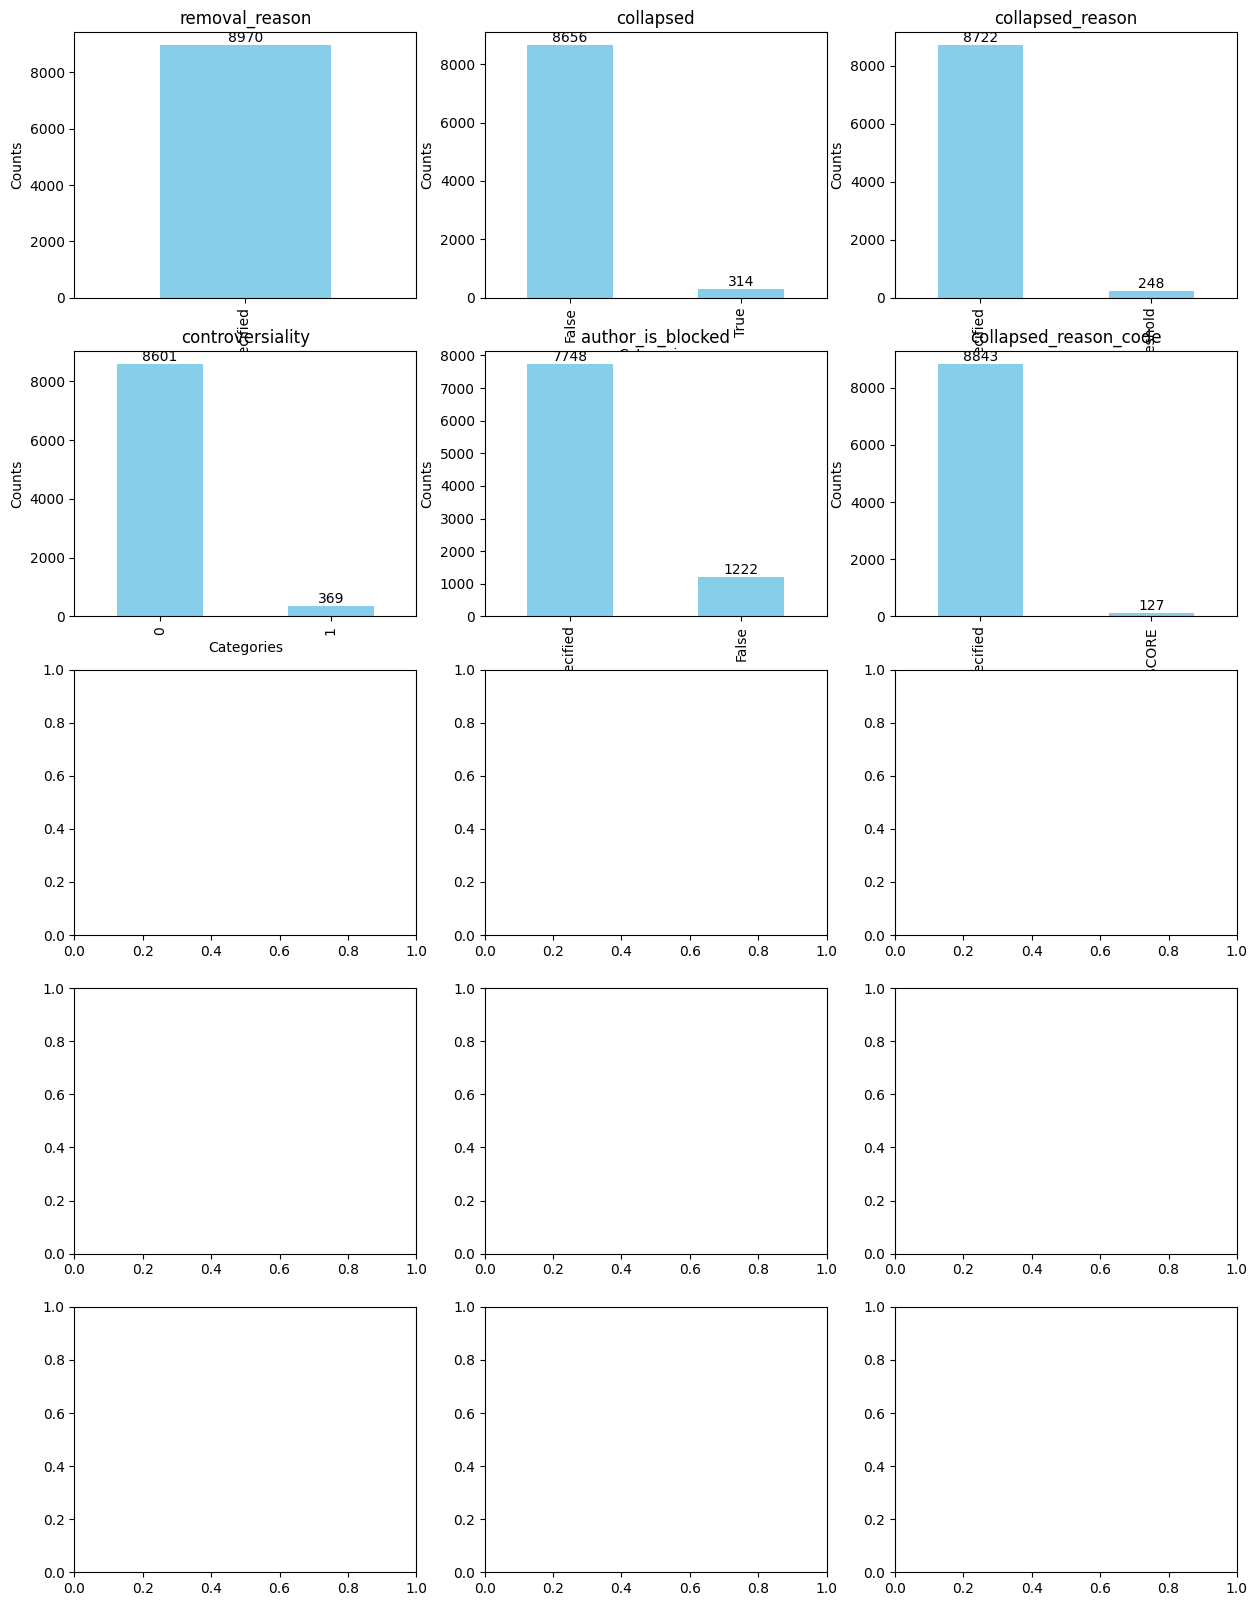

In [28]:
df_for_plot = df_normalized.copy()
df_for_plot.fillna('Not specified', inplace=True)


columns_to_plot = [
    'removal_reason',
    'collapsed', 
    'collapsed_reason', 
    'controversiality', 
    'author_is_blocked', 
    'collapsed_reason_code',
    'banned_at_utc', 
    'mod_reason_by', 
    'mod_reason_title', 
    'banned_by', 
    'num_reports', 
    'mod_note', 
    'report_reasons', 
    'mod_reports', 
    'user_reports'
]

num_columns = len(columns_to_plot)
cols = 3  
rows = (num_columns + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(15, 4 * rows))
axes = axes.flatten()

for i, column in enumerate(columns_to_plot):
    counts = df_for_plot[column].value_counts()
    if not counts.empty:
        bars = counts.plot(kind='bar', ax=axes[i], color='skyblue')
        axes[i].set_title(column)
        axes[i].set_xlabel('Categories')
        axes[i].set_ylabel('Counts')

        for bar in bars.patches:
            axes[i].annotate(format(int(bar.get_height())), 
                                (bar.get_x() + bar.get_width() / 2, bar.get_height()), 
                                ha='center', va='bottom')

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()  
plt.show()

# 2 Using LLMs to label our data

## hugging face login

In [19]:
api_key = os.getenv('HUGGINGFACE_API_KEY')

login(token=api_key)


## 2.1 hateBERT 

In [46]:
toxic_classifier = pipeline("text-classification", model="unitary/toxic-bert", return_all_scores=True, device=device)
hate_classifier = pipeline("text-classification", model="GroNLP/hateBERT", return_all_scores=True, device=device)

df_normalized['BERT_toxic'] = False
df_normalized['BERT_hateful'] = False

toxic_predictions = []
hate_predictions = []

# Iterate over the DataFrame and classify each text
for index, row in df_normalized.iterrows():
    # Get the text from the row
    text = row['text']

    # Use the toxicity classifier
    try:
        toxic_prediction = toxic_classifier(text, truncation=True)
        # Process the toxicity result
        for pred in toxic_prediction[0]:
            label = pred['label']
            score = pred['score']
            toxic_predictions.append((label, score))
            if label == 'toxic' and score > 0.5:  # Adjust threshold as needed
                df_normalized.at[index, 'BERT_toxic'] = True
    except RuntimeError as e:
        print(f"Error processing toxicity at index {index}: {e}")

    # Use the hatefulness classifier
    try:
        hate_prediction = hate_classifier(text, truncation=True)
        # Process the hatefulness result
        for pred in hate_prediction[0]:
            label = pred['label']
            score = pred['score']
            hate_predictions.append((label, score))
            if label == 'LABEL_0' and score > 0.5:  # Adjust threshold as needed
                df_normalized.at[index, 'BERT_hateful'] = True
    except RuntimeError as e:
        print(f"Error processing hatefulness at index {index}: {e}")


print(df_normalized[['text', 'BERT_toxic', 'BERT_hateful']].head())

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at GroNLP/hateBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


                                                text  BERT_toxic  BERT_hateful
0                                      STI chiong ah       False         False
1  Look bright side - never make mistake again, l...       False         False
2  posts flaired (by OP), exercising greater mode...       False         False
3                        sounds q fucked concern leh        True         False
4  Chinese media reported ago: https://www.zaobao...       False         False


In [48]:
print(df_normalized['BERT_hateful'].value_counts())
print(df_normalized['BERT_toxic'].value_counts())


BERT_hateful
False    8970
Name: count, dtype: int64
BERT_toxic
False    8301
True      669
Name: count, dtype: int64


## toxic-bert

In [20]:
model_name = 'unitary/toxic-bert'
url = f'https://api-inference.huggingface.co/models/{model_name}'
headers = {
    'Authorization': f'Bearer {api_key}'
}

## 2.2 Llama2
you will need to have HUGGINGFACE_API_KEY in your .env file

In [27]:
model_name = 'unitary/toxic-bert'

# Define the endpoint
url = f'https://api-inference.huggingface.co/models/{model_name}'

# Set up headers with your API key
headers = {
    'Authorization': f'Bearer {api_key}'
}

def classify_text(text):
    # Define the prompt for the model
    prompt = f"""Classify the following text into two categories: 

1. Determine if the text is "TOXIC" or "NOT_TOXIC".
2. Determine if the text is "HATEFUL" or "NOT_HATEFUL".

Text: "{text}"

Output Format: 
TOXIC: <result>
HATEFUL: <result>"""
    
    for attempt in range(5):  # Try up to 5 times
        # Make the API request
        response = requests.post(url, headers=headers, json={'inputs': prompt})
        
        # Check if the request was successful
        if response.status_code == 200:
            return response.json()  # The output will be in JSON format
        elif response.status_code == 503:
            print("Model is currently loading, retrying...")
            time.sleep(10)  # Wait for 10 seconds before retrying
        else:
            print(f"Error: {response.status_code} - {response.text}")
            return None

    print("Failed to classify text after multiple attempts.")
    return None

# Sample texts for classification
texts = [
    "I hate this product!",
    "This is a great community.",
    "I can't stand this behavior!"
]

# Classify each text
for text in texts:
    classification = classify_text(text)
    if classification:
        print(f"Text: '{text}'\nClassification: '{classification}'\n")

print(df_normalized.head())


In [9]:
llama3_classifier = pipeline("text-classification", model="meta-llama/Llama-3.1-8B", device=device)

# Sample texts for classification
texts = [
    "I hate this product!",
    "This community is amazing.",
    "I can't stand this behavior!",
    "What a wonderful experience!"
]

# Classify each text
for text in texts:
    classification = llama3_classifier(text)
    print(f"Text: '{text}'\nClassification: {classification}\n")

config.json:   0%|          | 0.00/826 [00:00<?, ?B/s]

c:\Users\Ethan\Documents\GitHub\DSA4264-Problem-2\.venv\Lib\site-packages\huggingface_hub\file_download.py:147: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Ethan\.cache\huggingface\hub\models--meta-llama--Llama-3.1-8B. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at meta-llama/Llama-3.1-8B and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/50.5k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/73.0 [00:00<?, ?B/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 224.00 MiB. GPU 0 has a total capacity of 8.00 GiB of which 0 bytes is free. Of the allocated memory 22.43 GiB is allocated by PyTorch, and 1.21 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)